In [2]:
import tensorflow.keras as keras # tf is a low model, every little detail, keras is high level api that they wrapped in tf2 
from tensorflow.keras.preprocessing import image # this is dependant on a lib pip install pillow 
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model

In [3]:
model = keras.applications.VGG16(weights='imagenet', include_top =True) # this means use the weights from when you trained the network on imagenet
model.summary()
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
import glob 
import random 
image_files = glob.glob('./metimages/*.jpg')

In [5]:
len(image_files)

52

In [6]:
random.shuffle(image_files)

In [7]:
import numpy as np
features = []

# for i, image_path in zip(range(0,len(image_files)), image_files) # same as below 

for i, image_path in enumerate(image_files): #it takes image_files and goes through and gives you each item and its associated index 
    if i % 10 == 0:
        print("analyzed " + str(i) + " out of " + str(len(image_files)))
    
    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img) # turning it into a numpy array 
    #print(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #print(x)
    
    feat = feat_extractor.predict(x)[0] # grabbing first value out of that prediction 
    #print(len(feat))
    features.append(feat)

analyzed 0 out of 52


/Users/shirley/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


analyzed 10 out of 52
analyzed 20 out of 52
analyzed 30 out of 52
analyzed 40 out of 52
analyzed 50 out of 52


In [9]:
# this is pre processing and transfors your data into an array using its features 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans # this is sensitive to distance, so standardscaler normalizes it to distance 

ss = StandardScaler()
scaled = ss.fit_transform(features)
scaled[0] # looks like everything is btwn 1 and -1 

array([-0.41662152,  0.62571809, -0.5484948 , ...,  2.65460934,
        3.46933301,  0.56419369])

In [ ]:
# !pip uninstall scikit-learn -y
# !pip install scikit-learn==1.0.1

In [10]:
# this clusters the image 
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(scaled)
clusters

array([2, 2, 3, 2, 4, 2, 2, 1, 0, 2, 3, 4, 1, 2, 0, 2, 1, 2, 1, 2, 2, 2,
       1, 2, 1, 2, 2, 4, 4, 4, 1, 4, 1, 2, 2, 4, 1, 2, 2, 2, 2, 1, 2, 2,
       4, 4, 2, 1, 1, 2, 2, 2], dtype=int32)

In [11]:
# plots it using k nearst neights 
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5, metric='cosine').fit(scaled)
_, closest = neighbors.kneighbors(kmeans.cluster_centers_)
#cosine works better in high dimension space, we haven't done any dimentionality reduction 


In [12]:
closest # index of all the images, 1st image, and the top 5 image by distance, list of a list 


array([[ 8, 14, 13, 21, 38],
       [30, 36, 41, 24, 18],
       [33, 19, 49,  5, 26],
       [10,  2, 35,  6, 27],
       [ 4, 45, 11, 44, 27]])

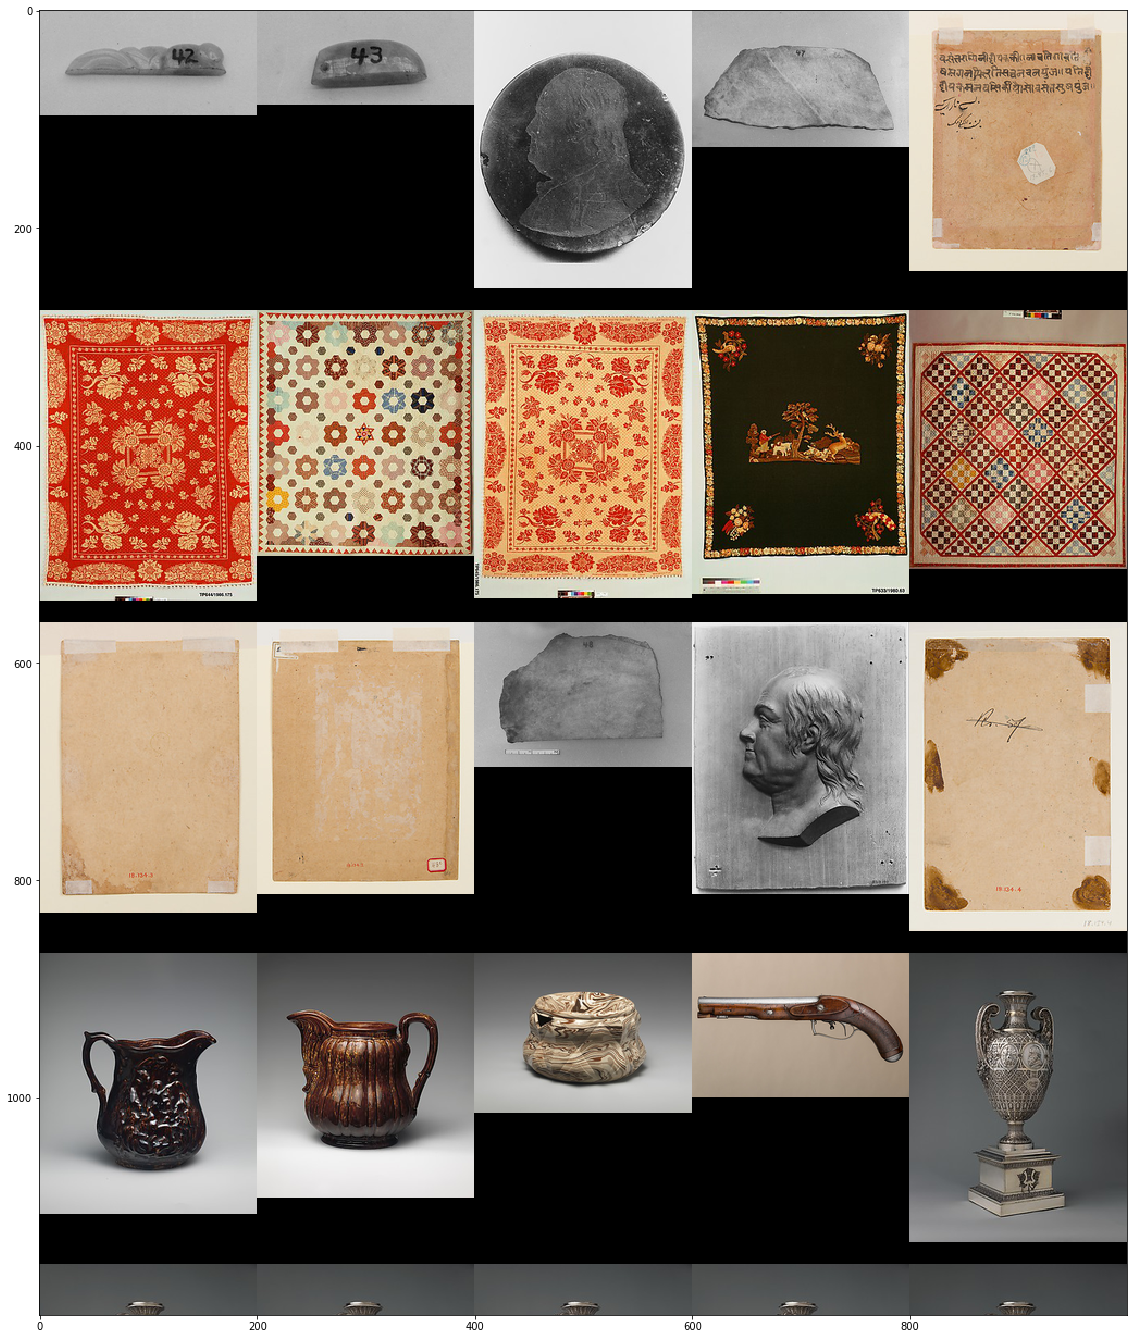

In [17]:
# plots it on a chart 

from PIL import Image
import matplotlib.pyplot as plt

img_width = 200

grid_image = Image.new('RGB', (5 * img_width, len(closest) * 240), (0, 0, 0, 255))

max_height = 0
for cluster_row in closest:
    max_height_temp = 0
    xpos = 0
    for col_num in cluster_row:
        img = Image.open(image_files[col_num])
        img_ar = img.width / img.height
        img = img.resize((img_width, int(img_width / img_ar)), Image.ANTIALIAS)
        max_height_temp = max(max_height_temp, img.height)
        grid_image.paste(img, (xpos, max_height))
        xpos = xpos + img.width
    max_height = max_height + max_height_temp + 20 # adding 20 pixel margin

plt.figure(figsize = (32,24))
plt.imshow(grid_image)

In [14]:
# UMAP is an algorithm for dimension reduction based on manifold learning techniques and ideas from topological data analysis
import umap.umap_ as umap
embedding = umap.UMAP().fit_transform(scaled)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(embedding)
embedding_scaled = scaler.transform(embedding)

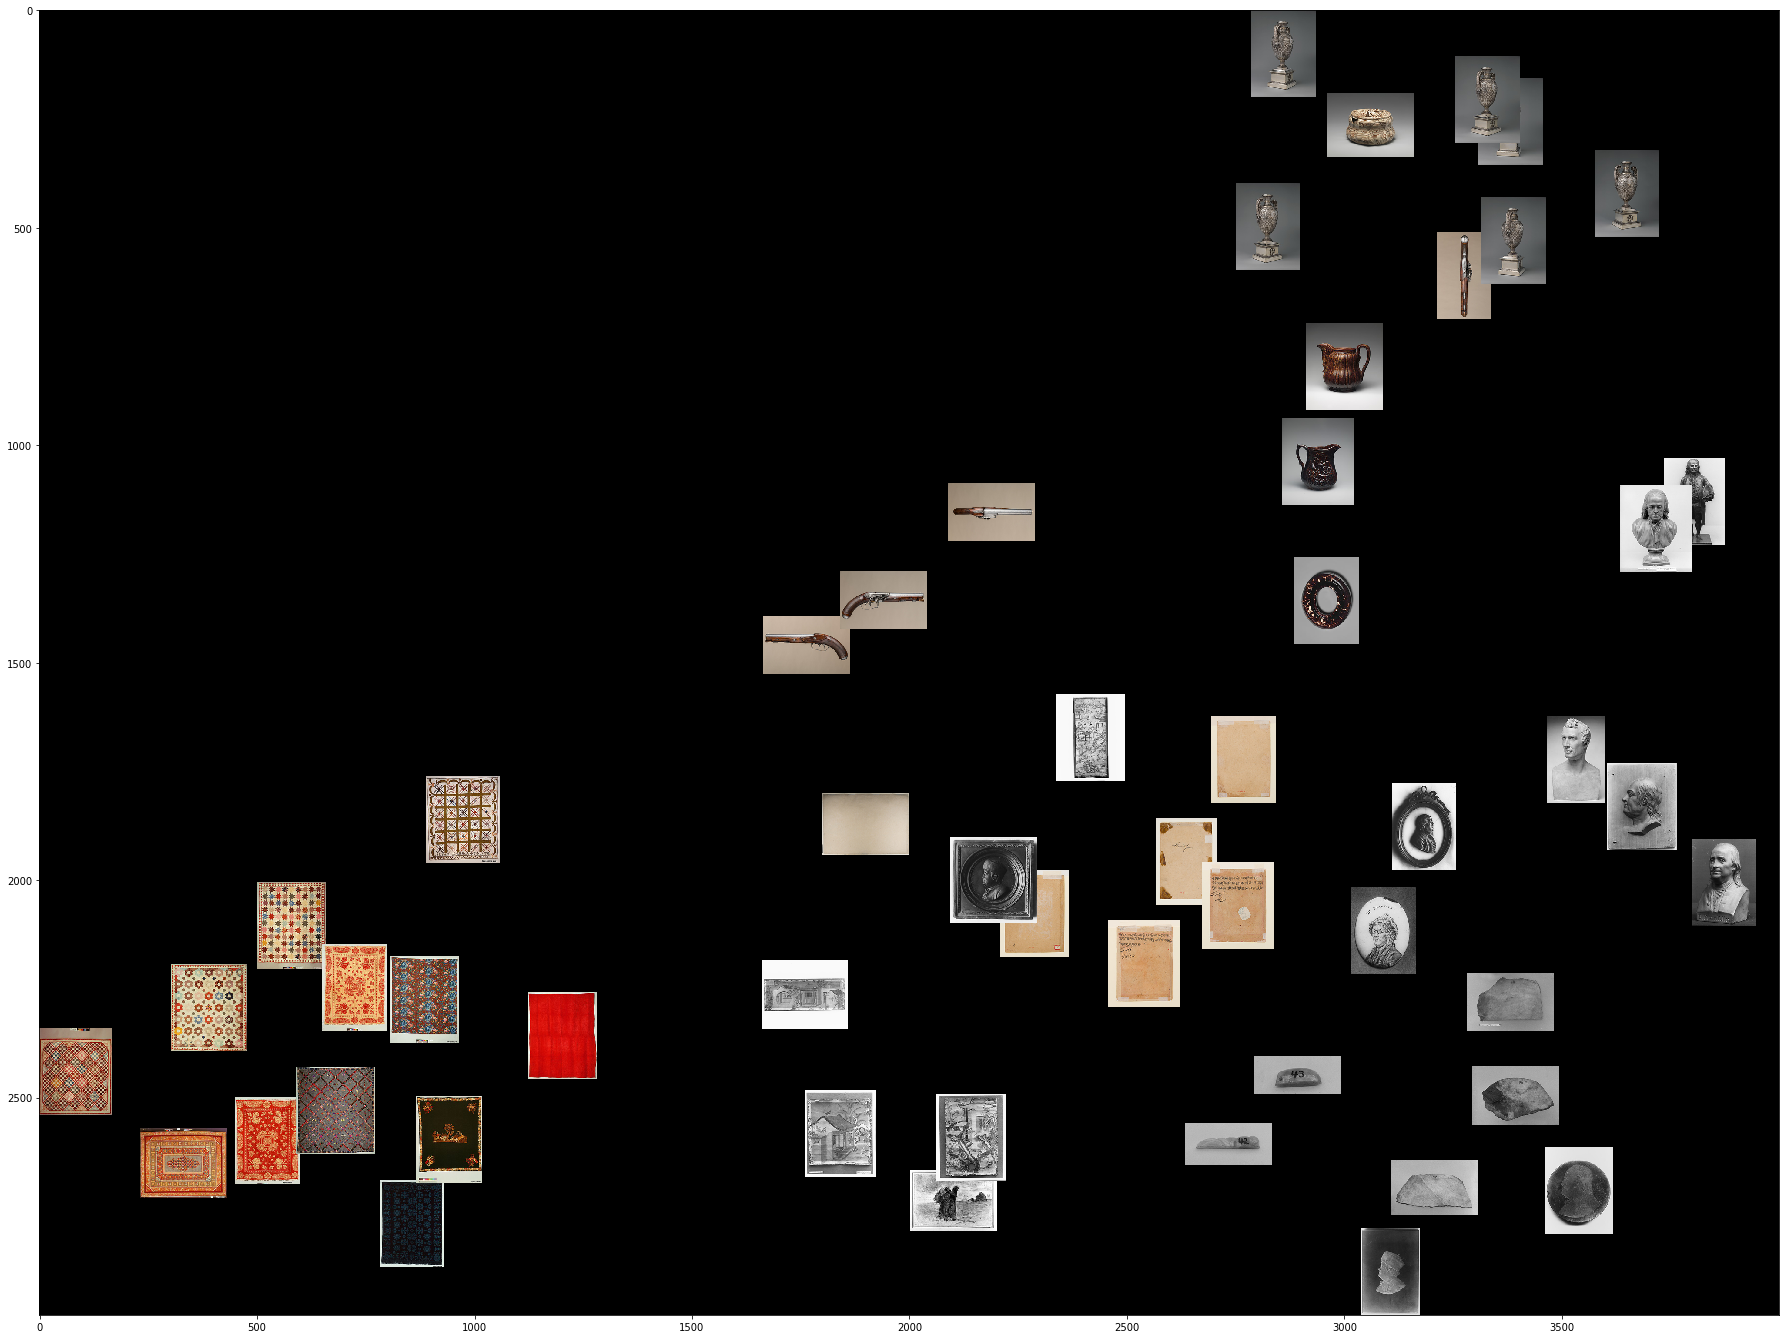

In [16]:
# plots clusters on a graph 
width = 4000
height = 3000
max_dim = 200

full_image = Image.new('RGBA', (width, height), (0, 0, 0, 255))
for img, pos in zip(image_files, embedding_scaled):
    x = pos[0]
    y = pos[1]
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (32,24))
plt.imshow(full_image)